In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp

import ct_projector.projector.cupy as ct_base
import ct_projector.projector.cupy.parallel as ct_proj

In [2]:
branchless = False

[[[[0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]]]]


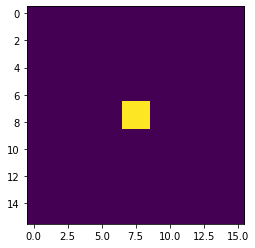

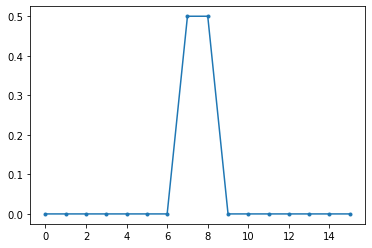

In [3]:
# forward projection inverse crime validation

img = np.zeros([1, 1, 16, 16], np.float32)
img[0, 0, 7:9, 7:9] = 1
plt.figure()
plt.imshow(img[0, 0])

projector_valid = ct_base.ct_projector()
projector_valid.nx = 16
projector_valid.ny = 16
projector_valid.nz = 1
projector_valid.cx = 0
projector_valid.cy = 0
projector_valid.cz = 0
projector_valid.dx = 0.25
projector_valid.dy = 0.25
projector_valid.dz = 1
projector_valid.nu = 16
projector_valid.nv = 1
projector_valid.du = 0.25
projector_valid.dv = 1
projector_valid.off_u = 0
projector_valid.off_v = 0

cuangles_valid = cp.zeros(1, cp.float32)

cuimg_valid = cp.array(img, order='C')
cufp_valid = ct_proj.distance_driven_fp(projector_valid, cuimg_valid, cuangles_valid, branchless)

fp_valid = cufp_valid.get()
plt.figure()
plt.plot(fp_valid[0, 0, 0, :], '.-')

print(fp_valid)

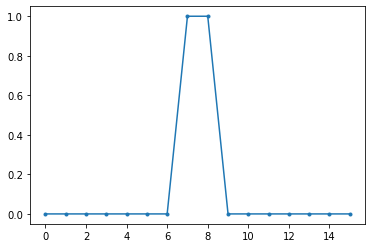

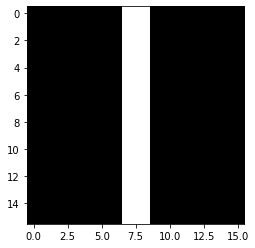

In [4]:
# backprojection inverse crime validation
prj = np.zeros([1, 1, 1, 16], np.float32)
prj[0, 0, 0, 7:9] = 1
plt.figure()
plt.plot(prj[0, 0, 0], '.-')

cuangles = cp.zeros(1, cp.float32)
cuprj = cp.array(prj, order='C')
cubp = ct_proj.distance_driven_bp(projector_valid, cuprj, cuangles, True, branchless)

bp = cubp.get()

plt.figure()
plt.imshow(bp[0, 0], 'gray', vmin=0, vmax=1)

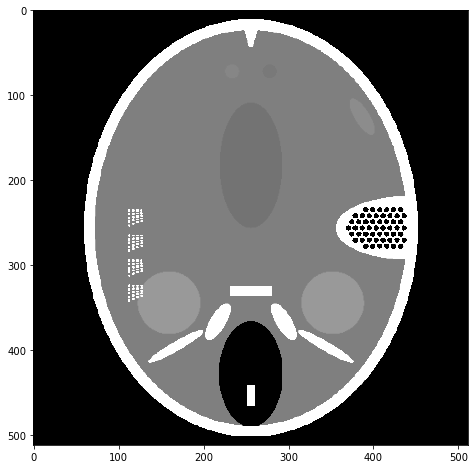

In [5]:
mat = scipy.io.loadmat('./forbild512.mat')
phantom = mat['ph']
phantom = phantom[np.newaxis, np.newaxis]

plt.figure(figsize=[8, 8])
plt.imshow(phantom[0, 0], 'gray', vmin=1, vmax=1.1)

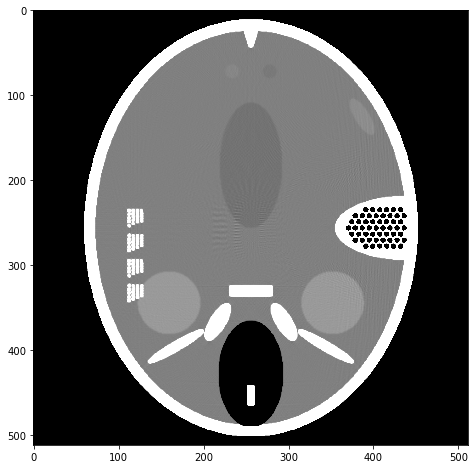

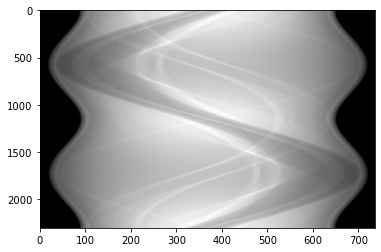

In [6]:

# read projector
projector = ct_base.ct_projector()
projector.from_file('projector_fan.cfg')
projector.nx = 512
projector.ny = 512
projector.dx = 1
projector.dy = 1
projector.nz = 1
projector.nv = 1
projector.cx = 0
projector.du = 0.7
angles = projector.get_angles()

cuphantom = cp.array(phantom, order='C')
cuangles = cp.array(angles, order='C')
cuprj = ct_proj.distance_driven_fp(projector, cuphantom, cuangles, branchless)
cufprj = ct_proj.ramp_filter(projector, cuprj, 'hann')
curecon = ct_proj.distance_driven_bp(projector, cufprj, cuangles, True, branchless)

recon = curecon.get()
plt.figure(figsize=[8, 8])
plt.imshow(recon[0, 0], 'gray', vmin=1, vmax=1.1)

prj = cuprj.get()
plt.figure()
plt.imshow(prj[0, :, 0, :], 'gray', aspect='auto')